<a href="https://colab.research.google.com/github/saeedghadiri/CovidVaccination/blob/main/CHR%26CovidVaccination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import
First we need to imprt stuff

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import sklearn.metrics as skm
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBRegressor as xgbr
import lightgbm as lgb

random_seed = 12345
sns.set_style("darkgrid")

# Download Data

## CHR
Download Country health ranking data from https://www.countyhealthrankings.org/ . 

In [ ]:
!wget https://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2021.csv
!wget https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2021.xlsx

--2022-01-16 15:59:58--  https://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2021.csv
Resolving www.countyhealthrankings.org (www.countyhealthrankings.org)... 104.18.13.242, 104.18.12.242, 2606:4700::6812:df2, ...
Connecting to www.countyhealthrankings.org (www.countyhealthrankings.org)|104.18.13.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘analytic_data2021.csv.1’

analytic_data2021.c     [ <=>                ]  11.90M  --.-KB/s    in 0.1s    

2022-01-16 15:59:59 (79.5 MB/s) - ‘analytic_data2021.csv.1’ saved [12481406]

--2022-01-16 15:59:59--  https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2021.xlsx
Resolving www.countyhealthrankings.org (www.countyhealthrankings.org)... 104.18.13.242, 104.18.12.242, 2606:4700::6812:df2, ...
Connecting to www.countyhealthrankings.org (www.countyhealthrankings.org)|104.18.13.242|:443... connected

## Vaccination
Download Reporting County-Level COVID-19 Vaccination Data from:

https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh

Description of data:

https://www.cdc.gov/coronavirus/2019-ncov/vaccines/distributing/reporting-counties.html

In [ ]:
!wget https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD
!mv rows.csv?accessType=DOWNLOAD vaccination_data.csv

--2022-01-16 15:59:59--  https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD
Resolving data.cdc.gov (data.cdc.gov)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cdc.gov (data.cdc.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [             <=>    ] 196.41M   510KB/s    in 7m 50s  

2022-01-16 16:07:50 (428 KB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [205954147]



# Load & Clean

## CHR



*   Delete columns that are numerator and denominator of divisions.
*   Delete columns that are cli high and cli low of 95% confidence interval.
*   Delete columns that are flag (not sure about this one)




In [ ]:
# TODO what should we do with _flags? what does it actually mean?
suffix_to_omit = ('_numerator', '_denominator', '_cilow', '_cihigh', '_flag')
df_chr = pd.read_csv("analytic_data2021.csv", header=[0,1])
cols = df_chr.columns.get_level_values(1).to_list()

cols = [item for item in cols if not item.endswith(suffix_to_omit)]
print('number of columns reduced from {} to {}'.format(len(df_chr.columns), len(cols)))
df_chr = df_chr.loc[:, df_chr.columns.get_level_values(1).isin(cols)]
df_chr.columns = df_chr.columns.droplevel(1)

usa_chr = df_chr.iloc[0] # keep chr data for usa; this may help us later
df_chr = df_chr.loc[1:].reset_index(drop=True)

states_chr = df_chr.loc[df_chr['County FIPS Code']==0] # keep chr data for states
df_chr = df_chr.loc[df_chr['County FIPS Code']!=0].reset_index(drop=True)

# let's rename 5-digit FIPS code since we are going to use it a lot
df_chr.rename({'5-digit FIPS Code':'FIPS'}, axis=1, inplace=True)
# and make it a string 5 digit code
df_chr['FIPS'] = df_chr['FIPS'].astype(str).str.zfill(5)

print("number of rows for chr data: {}".format(len(df_chr)))

df_chr.head(5)

number of columns reduced from 690 to 201
number of rows for chr data: 3142


,State FIPS Code,County FIPS Code,FIPS,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death (AIAN),Premature death (Asian/Pacific Islander),Premature death (Black),Premature death (Hispanic),Premature death (White),Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Low birthweight raw value,Low birthweight (AIAN),Low birthweight (Asian/Pacific Islander),Low birthweight (Black),Low birthweight (Hispanic),Low birthweight (White),Adult smoking raw value,Adult obesity raw value,Food environment index raw value,Physical inactivity raw value,Access to exercise opportunities raw value,Excessive drinking raw value,Alcohol-impaired driving deaths raw value,Sexually transmitted infections raw value,Teen births raw value,Teen births (AIAN),Teen births (Asian/Pacific Islander),Teen births (Black),Teen births (Hispanic),Teen births (White),Uninsured raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Dentists raw value,...,Residential segregation - Black/White raw value,Residential segregation - non-White/White raw value,Homicides raw value,Homicides (AIAN),Homicides (Asian/Pacific Islander),Homicides (Black),Homicides (Hispanic),Homicides (White),Suicides raw value,Crude suicide rate,Suicides (AIAN),Suicides (Asian/Pacific Islander),Suicides (Black),Suicides (Hispanic),Suicides (White),Firearm fatalities raw value,Firearm fatalities (AIAN),Firearm fatalities (Asian/Pacific Islander),Firearm fatalities (Black),Firearm fatalities (Hispanic),Firearm fatalities (White),Juvenile arrests raw value,Number of juvenile delinquency cases formally processed by a juvenile court,Number of informally handled juvenile delinquency cases,Traffic volume raw value,Homeownership raw value,Severe housing cost burden raw value,Broadband access raw value,Population raw value,% below 18 years of age raw value,% 65 and older raw value,% Non-Hispanic Black raw value,% American Indian & Alaska Native raw value,% Asian raw value,% Native Hawaiian/Other Pacific Islander raw value,% Hispanic raw value,% Non-Hispanic White raw value,% not proficient in English raw value,% Females raw value,% Rural raw value
0,1,1,01001,AL,Autauga County,2021,1.0,7830.053484,NaN,NaN,10728.779278,NaN,7245.050837,0.198392,4.501499,4.850214,0.092018,NaN,NaN,0.138203,NaN,0.079190,0.198108,0.330,6.7,0.306,0.691301,0.144739,0.333333,504.5,23.764041,NaN,NaN,28.852920,NaN,23.144785,0.100473,0.000468,2138.500000,0.000340,...,24.791239,24.192062,5.407103,NaN,NaN,14.493708,NaN,3.396093,18.483525,19.442854,NaN,NaN,NaN,NaN,22.148215,16.562431,NaN,NaN,NaN,NaN,18.606249,NaN,68.0,-888.0,155.095523,0.732906,0.133759,0.805674,55869,0.232061,0.159731,0.198643,0.004761,0.011742,0.001038,0.029909,0.737708,0.008033,0.515080,0.420022
1,1,3,01003,AL,Baldwin County,2021,1.0,7680.477270,NaN,NaN,10269.265146,4223.397220,7707.947014,0.164607,3.647978,4.768294,0.082920,NaN,0.094527,0.148787,0.061014,0.075503,0.185133,0.300,7.8,0.247,0.737135,0.187370,0.296089,297.2,26.006904,NaN,NaN,32.936713,44.971382,24.327138,0.131690,0.000702,1424.980392,0.000493,...,42.496933,31.840280,3.009973,NaN,NaN,8.014922,NaN,2.683778,19.287661,19.509340,NaN,NaN,NaN,NaN,22.050822,14.350620,NaN,NaN,NaN,NaN,15.937605,28.392857,458.0,178.0,133.604842,0.752453,0.111740,0.818164,223234,0.213023,0.209780,0.086076,0.007803,0.010661,0.000690,0.047188,0.832073,0.007085,0.515096,0.422791
2,1,5,01005,AL,Barbour County,2021,1.0,11476.629416,NaN,NaN,13845.807425,NaN,9424.322115,0.298415,5.569267,5.590494,0.113553,NaN,NaN,0.151099,NaN,0.071320,0.255308,0.412,5.5,0.280,0.531668,0.124670,0.393939,755.8,37.114262,NaN,NaN,37.988827,56.603774,34.006376,0.135040,0.000322,3110.125000,0.000365,...,19.722576,19.814479,10.482527,NaN,NaN,17.178982,NaN,NaN,11.325918,12.569624,NaN,NaN,NaN,NaN,21.375266,21.211240,NaN,NaN,19.486214,NaN,25.407365,NaN,14.0,-888.0,102.459673,0.608989,0.142707,0.605243,24686,0.205866,0.196913,0.47

First let's deal with nan values.

plot ditribution for percentage of nan values for columns.

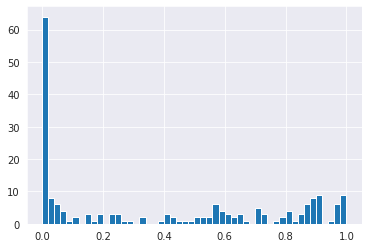

count    194.000000
mean       0.385264
std        0.379453
min        0.000000
25%        0.005490
50%        0.255570
75%        0.779122
max        1.000000
dtype: float64


In [ ]:
data_cols = df_chr.columns[7:]
nan_columns = df_chr[data_cols].isna().sum()/len(df_chr)
nan_columns.hist(bins=50)
plt.show()
print(nan_columns.describe())

As you can see 50% of columns are filled with nan for more than 51% of their data. 

We can use 2 different approaches to deal with nans:

*   Drop the last quantile of columns which have more than 90% nans in their data and replace nans with a non-meaningful value (maybe zero) or the mean.
*   Use only the first quantile of columns that have less than 0.4% nans in their data.

First let's check whether we can use zero for the nan values.




Food environment index raw value                                                  1
Access to exercise opportunities raw value                                       18
Alcohol-impaired driving deaths raw value                                       153
Primary care physicians raw value                                                67
Ratio of population to primary care physicians.                                  67
Dentists raw value                                                              145
Ratio of population to dentists.                                                145
Mental health providers raw value                                                35
Ratio of population to mental health providers.                                  35
Children in single-parent households raw value                                    4
Social associations raw value                                                   138
Violent crime raw value                                                     

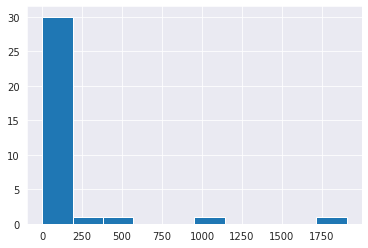

In [ ]:
zero_cols = (df_chr[data_cols] <= 0).sum()
zero_cols = zero_cols[zero_cols>0]
print(zero_cols)
zero_cols.hist()

Therefore zero actually has meaning in some columns so we at least cannot replace nan for every column with zero.

So for now I choose the first method and use columns with the fewer number of nans.

In [ ]:
selected_cols = nan_columns[nan_columns < nan_columns.quantile(0.25)]
selected_cols = selected_cols.keys()
print('number of selected columns with few nan values: {}'.format(len(selected_cols)))
print('reduced number of rows from {} to {}'.format( len(df_chr),len(df_chr[selected_cols].dropna())))
index_data = df_chr[selected_cols].dropna().index

df_chr = df_chr.loc[index_data, df_chr.columns[:7].tolist() + selected_cols.tolist()]

number of selected columns with few nan values: 49
reduced number of rows from 3142 to 3108


Now we check correlations and distribution of each feature.

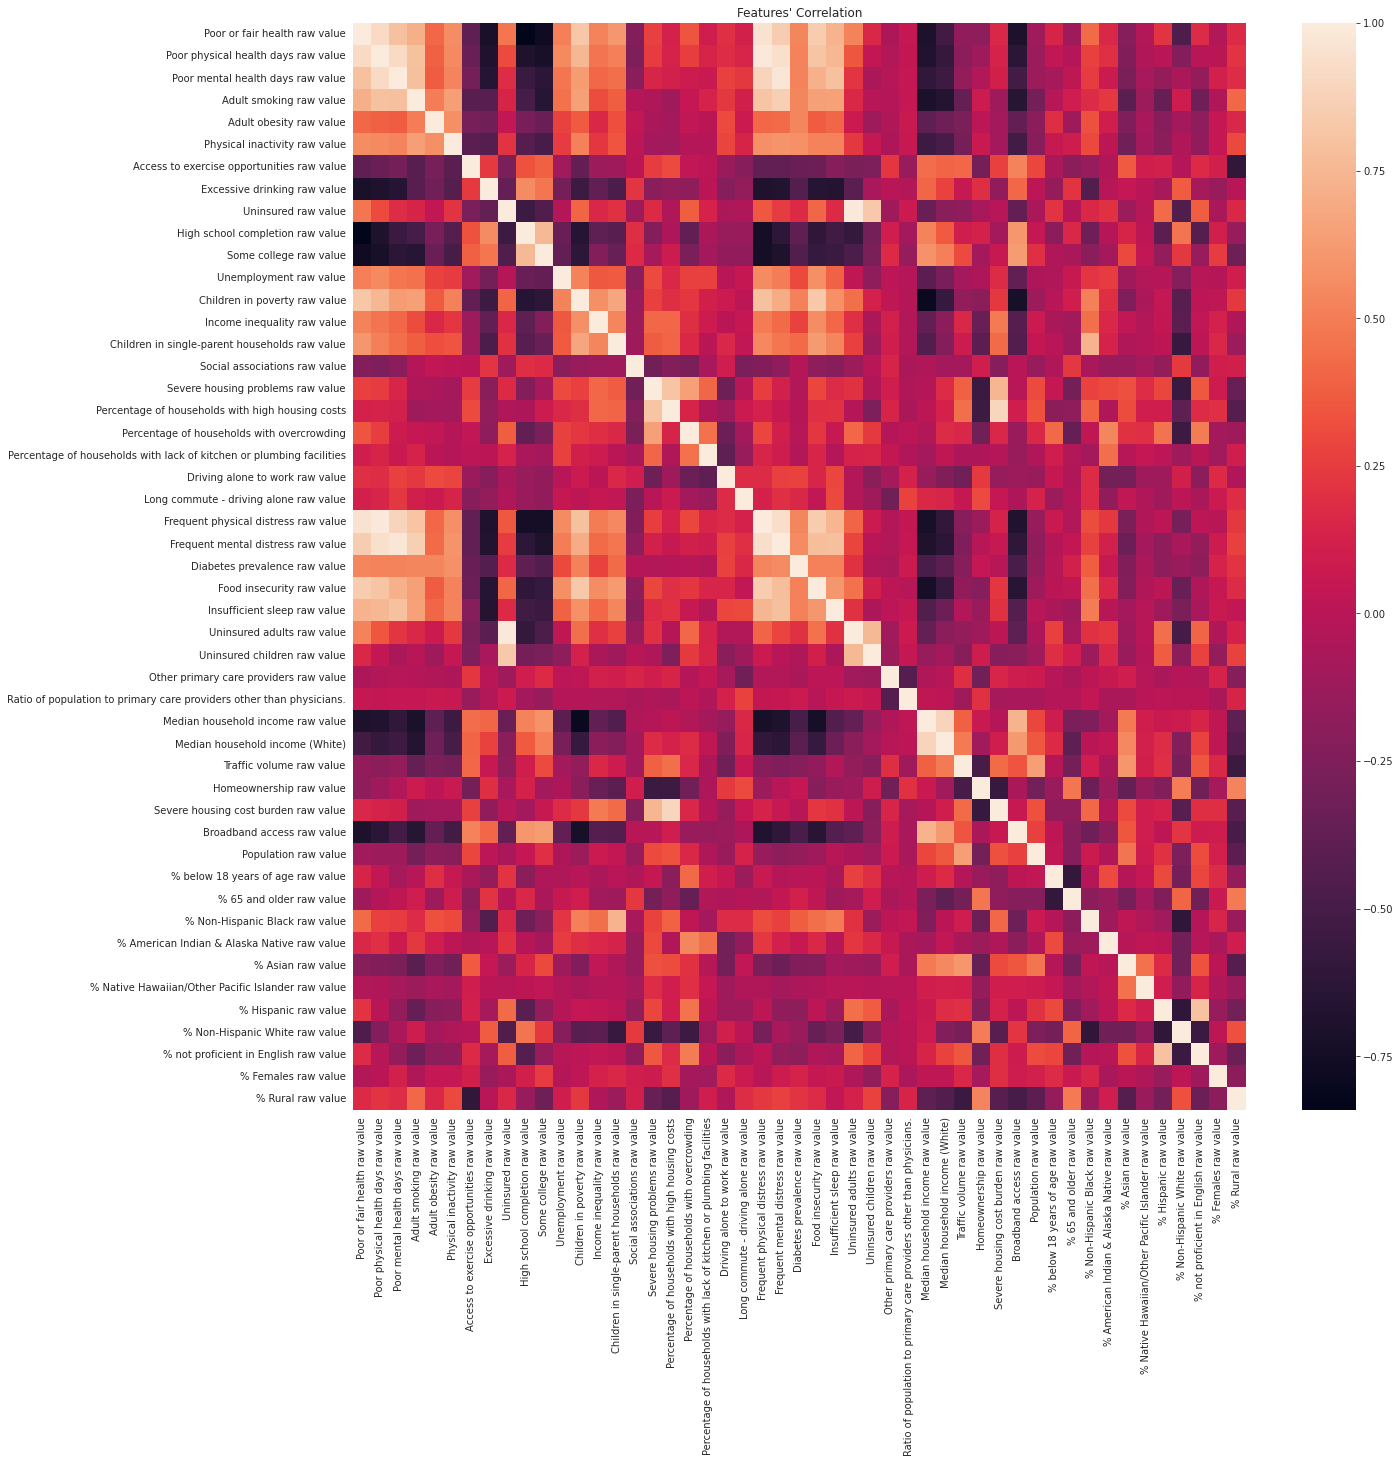

In [ ]:
plt.figure(figsize=(20, 20))
co = df_chr[selected_cols].corr()
sns.heatmap(co)
plt.title("Features' Correlation")
plt.show()

<Figure size 432x288 with 0 Axes>

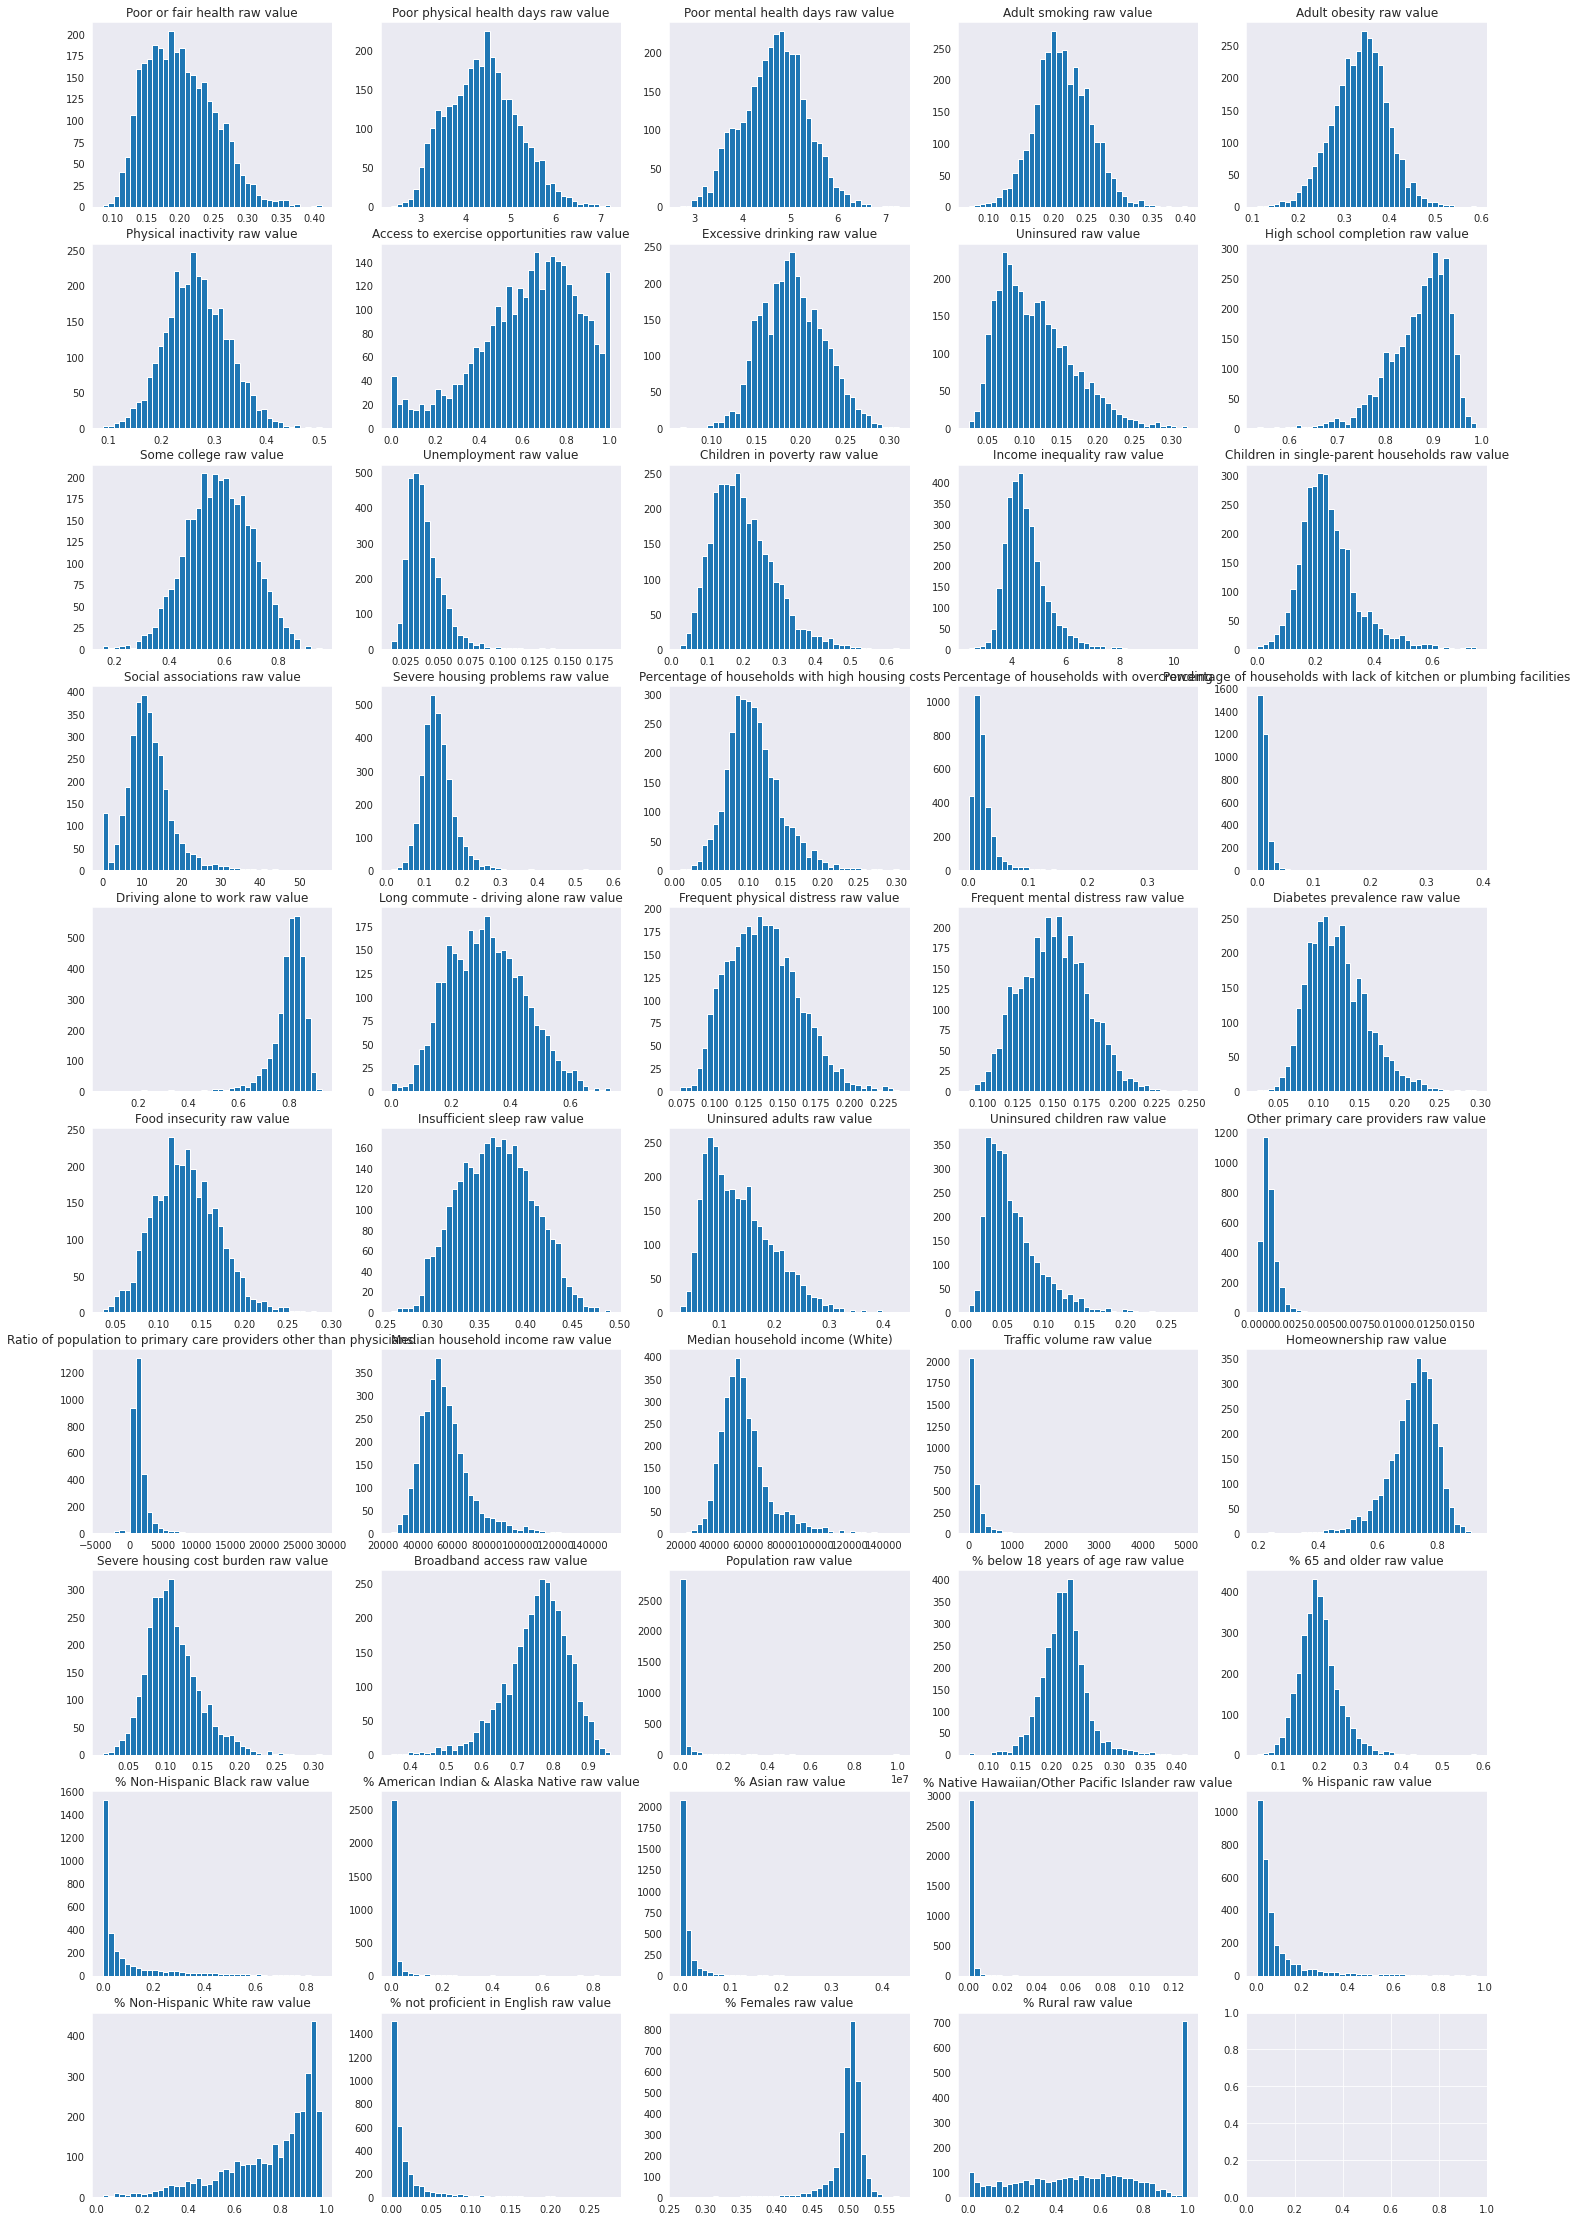

In [ ]:
plt.figure()
fig, ax = plt.subplots(int(len(selected_cols)/5) + 1, 5, figsize=(25, int(len(selected_cols)/1.2)))

for i, col in enumerate(selected_cols):
  ax[i // 5, i % 5].hist(df_chr[col], bins=40)
  ax[i // 5, i % 5].set(title=col)
  ax[i // 5, i % 5].grid()
plt.show()

## Vaccination

In [ ]:
df_vaccination = pd.read_csv("vaccination_data.csv")
print("number of rows for vaccination data: {}".format(len(df_vaccination)))
df_vaccination.head()

number of rows for vaccination data: 1309394


,Date,FIPS,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,Series_Complete_5Plus,Series_Complete_5PlusPop_Pct,Series_Complete_5PlusPop_Pct_SVI,Series_Complete_5PlusPop_Pct_UR_Equity,Booster_Doses,Booster_Doses_18Plus,Booster_Doses_50Plus,Booster_Doses_65Plus,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Booster_Doses_50Plus_Vax_Pct,Booster_Doses_65Plus_Vax_Pct
0,01/15/2022,06051,2,Mono County,CA,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A,NaN,NaN,NaN,NaN,Non-metro,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/15/2022,01083,2,Limestone County,AL,35.2,34772,34527.0,40.7,33046,43.0,10181,67.5,92.8,40755.0,41.2,40284.0,47.5,38534.0,50.1,11330.0,75.1,C,10.0,11.0,11.0,11.0,Metro,2.0,3.0,3.0,3.0,40755.0,43.6,34772.0,37.2,10.0,2.0,9910.0,9861.0,8089.0,5317.0,28.5,29.8,39.8,52.2
2,01/15/2022,13119,2,Franklin County,GA,17.3,4040,4014.0,20.1,3808,20.9,981,21.9,60.0,4049.0,17.3,NaN,0.0,NaN,0.0,NaN,0.0,D,13.0,13.0,13.0,13.0,Non-metro,5.0,5.0,5.0,5.0,0.0,0.0,4040.0,18.4,13.0,5.0,2425.0,2417.0,1944.0,1322.0,60.0,63.5,92.7,95.0
3,01/15/2022,13095,2,Dougherty County,GA,29.0,25489,25160.0,34.0,22778,33.9,4276,29.5,60.0,25989.0,29.5,NaN,0.0,NaN,0.0,NaN,0.0,D,13.0,14.0,14.0,13.0,Metro,1.0,2.0,2.0,1.0,0.0,0.0,25489.0,31.0,14.0,2.0,13043.0,12947.0,10063.0,6205.0,51.2,56.8,91.3,95.0
4,01/15/2022,27051,2,Grant County,MN,53.1,3173,3117.0,61.4,2951,63.8,1211,84.5,94.6,3384.0,56.7,3304.0,65.1,3126.0,67.6,1262.0,88.1,A,4.0,4.0,4.0,4.0,Non-metro,8.0,8.0,8.0,8.0,3384.0,60.1,3173.0,56.3,4.0,8.0,1594.0,1586.0,1267.0,860.0,50.2,53.7,62.5,71.0



Exceptions to County-Level Data for Vaccination
*   **California** does not report the county of residence for persons receiving a vaccine when the resident’s county has a population of fewer than 20,000 people.
*   **Hawaii** does not provide CDC with county-of-residence information.
*   **Massachusetts** does not provide vaccination data for Barnstable, Dukes, and Nantucket counties because of their small populations.
*   **New Hampshire** lifted its national COVID-19 emergency response declaration in May 2021, which allows vaccine recipients to opt out of having their COVID-19 vaccinations included in the state’s Immunization Information System registry. As such, data submitted by New Hampshire since May 2021 may not be representative of all COVID-19 vaccination occurring in the state.

In [ ]:
ingonred_CA = ["06003", "06027", "06043", "06049", "06051", "06063", "06091", "06105"] # California ignored FIPS
ignored_HI = ["15001", "15003", "15005", "15007", "15009"] # Hawaii ignored FIPS
ignored_MA = ["25001", "25007", "25019"] # Massachusetts ignored FIPS
ignored_NH = ['UNK', '33005', '33011', '33017', '33013', '33009', '33019', '33007', '33001', '33015', '33003'] # New Hampshired ignored FIPS
ingored_FIPS = ingonred_CA + ignored_HI + ignored_MA + ignored_NH

we have 4 targets to choose from:


*   **Series_Complete_Pop_Pct**: 	Percent of people who are fully vaccinated (have second dose of a two-dose vaccine or one dose of a single-dose vaccine) based on the jurisdiction and county where recipient lives.

*   **Series_Complete_12PlusPop_Pct**: Total number of people 12+ who are fully vaccinated (have second dose of a two-dose vaccine or one dose of a single-dose vaccine) based on the jurisdiction where recipient lives.

*   **Series_Complete_18PlusPop_Pct**: Total number of people 12+ who are fully vaccinated (have second dose of a two-dose vaccine or one dose of a single-dose vaccine) based on the jurisdiction where recipient lives.

*   **Completeness_pct**: Represents the proportion of fully vaccinated people whose Federal Information Processing Standards (FIPS) code is reported and matches a valid county FIPS code in the jurisdiction.  

for now we use **Series_Complete_Pop_Pct**.

get vaccination data by the end of 2021 for each county

number of rows for vaccination data: 3198
number of rows for vaccination data after cleaning: 3182
    FIPS       Date  ...  Booster_Doses_50Plus_Vax_Pct Booster_Doses_65Plus_Vax_Pct
0  01001 2021-12-31  ...                          36.5                         46.0
1  01003 2021-12-31  ...                          37.5                         45.8
2  01005 2021-12-31  ...                          34.0                         44.6

[3 rows x 46 columns]


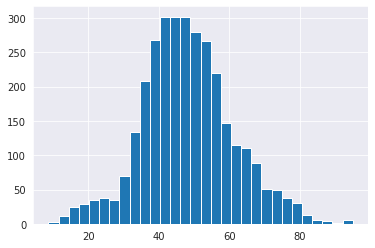

In [ ]:
target_column = 'Series_Complete_Pop_Pct'

df_vaccination = df_vaccination[~df_vaccination['FIPS'].isin(ingored_FIPS)] # drop ignored county data

df_vaccination['Date'] = pd.to_datetime(df_vaccination['Date'])
df_vaccination = df_vaccination[(df_vaccination['Date'] <= '12/31/2021') & (df_vaccination['Date'] >= '12/01/2021')] # get data before 2022
df_vaccination = df_vaccination.sort_values(by=['Date', 'FIPS'], ascending=True)
df_vaccination = df_vaccination.groupby('FIPS', as_index=False).last() # get the latest available data for 2021

print("number of rows for vaccination data: {}".format(len(df_vaccination)))
# ignore counties with 0 percent vaccination data
ingored_FIPS = ingored_FIPS + df_vaccination.loc[df_vaccination[target_column] == 0, "FIPS"].to_list()
df_vaccination = df_vaccination[~df_vaccination['FIPS'].isin(ingored_FIPS)]

print("number of rows for vaccination data after cleaning: {}".format(len(df_vaccination)))

print(df_vaccination.head(3))

df_vaccination[target_column].hist(bins=30)
plt.show()

Let's take a look at the right tale.

In [ ]:
df_vaccination[df_vaccination[target_column] > 85]

,FIPS,Date,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,Series_Complete_5Plus,Series_Complete_5PlusPop_Pct,Series_Complete_5PlusPop_Pct_SVI,Series_Complete_5PlusPop_Pct_UR_Equity,Booster_Doses,Booster_Doses_18Plus,Booster_Doses_50Plus,Booster_Doses_65Plus,Booster_Doses_Vax_Pct,Booster_Doses_18Plus_Vax_Pct,Booster_Doses_50Plus_Vax_Pct,Booster_Doses_65Plus_Vax_Pct
71,02060,2021-12-31,52,Bristol Bay Borough,AK,95.0,824,816.0,95.0,772,95.0,122,89.7,96.7,1044.0,95.0,1018.0,95.0,966.0,95.0,132.0,95.0,B,8.0,8.0,8.0,8.0,Non-metro,8.0,8.0,8.0,8.0,1044.0,95.0,824.0,95.0,8.0,8.0,270.0,267.0,181.0,93.0,32.8,34.6,59.2,76.2
96,04001,2021-12-31,52,Apache County,AZ,88.8,63856,60802.0,95.0,51920,95.0,12249,95.0,97.7,78385.0,95.0,73044.0,95.0,62815.0,95.0,14202.0,95.0,D,16.0,16.0,16.0,16.0,Non-metro,8.0,8.0,8.0,8.0,78376.0,95.0,63853.0,95.0,16.0,8.0,23196.0,22801.0,14606.0,7532.0,36.3,43.9,55.4,61.5
108,04023,2021-12-31,52,Santa Cruz County,AZ,95.0,46340,44962.0,95.0,39583,95.0,9225,95.0,97.7,57776.0,95.0,54088.0,95.0,45468.0,95.0,10342.0,95.0,D,16.0,16.0,16.0,16.0,Non-metro,8.0,8.0,8.0,8.0,57773.0,95.0,46340.0,95.0,16.0,8.0,11322.0,11262.0,7765.0,4622.0,24.4,28.5,41.8,50.1
292,08111,2021-12-31,52,San Juan County,CO,90.0,655,649.0,95.0,618,95.0,156,83.0,97.3,754.0,95.0,718.0,95.0,686.0,95.0,173.0,92.0,A,4.0,4.0,4.0,4.0,Non-metro,8.0,8.0,8.0,8.0,754.0,95.0,655.0,93.4,4.0,8.0,299.0,297.0,175.0,114.0,45.6,48.1,55.7,73.1
404,13053,2021-12-31,52,Chattahoochee County,GA,95.0,40574,40408.0,95.0,38891,95.0,2190,95.0,59.8,44486.0,95.0,44112.0,95.0,42183.0,95.0,2467.0,95.0,C,12.0,12.0,12.0,12.0,Metro,4.0,4.0,4.0,4.0,44485.0,95.0,40573.0,95.0,12.0,4.0,382.0,379.0,276.0,169.0,0.9,1.0,3.7,7.7
2685,48377,2021-12-31,52,Presidio County,TX,95.0,6444,6276.0,95.0,5767,95.0,1686,95.0,99.1,7989.0,95.0,7638.0,95.0,6912.0,95.0,1971.0,95.0,D,16.0,16.0,16.0,16.0,Non-metro,8.0,8.0,8.0,8.0,7988.0,95.0,6444.0,95.0,16.0,8.0,1739.0,1722.0,1219.0,673.0,27.0,29.9,37.6,39.9
2916,51740,2021-12-31,52,Portsmouth city,VA,87.3,82392,81787.0,95.0,78907,95.0,15209,95.0,80.6,92090.0,95.0,90938.0,95.0,87480.0,95.0,16971.0,95.0,D,16.0,16.0,16.0,16.0,Metro,4.0,4.0,4.0,4.0,92086.0,95.0,82389.0,94.1,16.0,4.0,8489.0,8458.0,6768.0,4267.0,10.3,10.7,20.4,28.1
3112,56039,2021-12-31,52,Teton County,WY,88.7,20813,20149.0,95.0,18960,95.0,3603,95.0,96.5,24024.0,95.0,23207.0,95.0,21881.0,95.0,4070.0,95.0,A,4.0,4.0,4.0,4.0,Non-metro,8.0,8.0,8.0,8.0,24022.0,95.0,20813.0,93.2,4.0,8.0,7798.0,7777.0,4579.0,2499.0,37.5,41.0,56.7,69.4
3121,72009,2021-12-31,52,Aibonito Municipio,PR,85.2,18842,18209.0,92.4,16740,92.2,4417,91.2,95.9,20655.0,93.4,19738.0,95.0,18169.0,95.0,4787.0,95.0,B,8.0,8.0,8.0,8.0,Metro,4.0,4.0,4.0,4.0,20651.0,95.0,18839.0,88.7,8.0,4.0,6670.0,6649.0,4428.0,2410.0,35.4,39.7,49.4,54.6
3123,72013,2021-12-31,52,Arecibo Municipio,PR,95.0,99682,97398.0,95.0,88949,95.0,22221,95.0,95.9,106714.0,95.0,102715.0,95.0,93568.0,95.0,25370.0,95.0,B,8.0,8.0,8.0,8.0,Metro,4.0,4.0,4.0,4.0,106677.0,95.0,99672.0,95.0,8.0,4.0,30311.0,30194.0,20433.0,11436.0,30.4,33.9,46.3,51.5


As you can see, There are counties with exactly 95 percent of vaccination for their **Series_Complete_Pop_Pct** and 12+, 18+ and 65+, which is kind of suspicous. 

Therefore I write this section in order to make sure to delete them from dataset.

In [ ]:
# ignore counties with 95 percent vaccination data
ingored_FIPS = ingored_FIPS + df_vaccination.loc[df_vaccination[target_column] == 95, "FIPS"].to_list()
df_vaccination = df_vaccination[~df_vaccination['FIPS'].isin(ingored_FIPS)]
# check for nans
print('number of nans: {}'.format(df_vaccination[target_column].isna().sum()))
print(df_vaccination[target_column].describe())
print('number of unique dates: {}'.format(len(df_vaccination['Date'].unique())))
df_vaccination = df_vaccination[['FIPS',target_column]]
df_vaccination.columns = ['FIPS', 'vaccination']

number of nans: 0
count    3176.000000
mean       48.064861
std        12.808966
min         8.700000
25%        39.800000
50%        47.300000
75%        55.800000
max        90.000000
Name: Series_Complete_Pop_Pct, dtype: float64
number of unique dates: 1


# Merge and Split train test
In this section we merge chr and vaccination data.

In [ ]:
# first remove ignored ones from chr data
df_chr = df_chr.loc[~df_chr['FIPS'].isin(ingored_FIPS)]

df = pd.merge(df_chr,df_vaccination, on='FIPS', how='inner')

print('chr size: {}   vaccination size: {}   total size: {}'.format(len(df_chr), len(df_vaccination), len(df)))

# split
x_train, x_test, y_train, y_test = train_test_split(df[selected_cols], df['vaccination'], test_size=0.2, random_state=random_seed)
print('train_shape : {}'.format(x_train.shape))
print('test_shape : {}'.format(x_test.shape))

chr size: 3070   vaccination size: 3176   total size: 3070
train_shape : (2456, 49)
test_shape : (614, 49)


# Model

In [ ]:
# utils methods
def calc_metrics(y, y_pred):
  mae = skm.mean_absolute_error(y, y_pred)
  r2 = skm.r2_score(y, y_pred)
  rmse = np.sqrt(skm.mean_squared_error(y, y_pred))
  corr = np.corrcoef(y, y_pred)[0,1]
  print_str = 'MAE: {:.2f} R2: {:.2f} RMSE: {:.2f} Corr: {:.2f}'.format(mae, r2, rmse, corr)
  return {'mae':mae, 'r2':r2, 'rmse':rmse, 'corr':corr}, print_str

def cv_train_and_evaluate(model, param_grid, x_train, y_train, x_test, y_test, model_name, n_folds=5, scoring='r2'):

  clf = GridSearchCV(model, param_grid, cv=n_folds, scoring= scoring, refit=True)
  clf.fit(x_train, y_train)
  y_train_pred = clf.predict(x_train)
  y_test_pred = clf.predict(x_test)

  metrics_train, metric_str = calc_metrics(y_train ,y_train_pred)
  print ('{} Train = {}'.format(model_name, metric_str))
  metrics_test, metric_str = calc_metrics(y_test ,y_test_pred)
  print ('{} Train = {}'.format(model_name, metric_str))
  return metrics_train, metrics_test



## Lasso Regression

In [ ]:
lasso = Lasso(random_state=random_seed, max_iter=10000)
alphas = np.logspace(-4, -0.001, 30)
param_grid = [{'alpha': alphas}]

_, _ = cv_train_and_evaluate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+03, tolerance: 2.910e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.962e+02, tolerance: 2.910e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Lasso Train = MAE: 6.11 R2: 0.56 RMSE: 8.10 Corr: 0.75
Lasso Train = MAE: 6.20 R2: 0.58 RMSE: 8.29 Corr: 0.76


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e+03, tolerance: 3.650e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Decision Tree Regression

In [ ]:
decision_tree_model = DecisionTreeRegressor(random_state=random_seed)

param_grid = [{'max_leaf_nodes': np.logspace(1, 4, 30, dtype=int)}]

_, _ = cv_train_and_evaluate(decision_tree_model, param_grid, x_train, y_train, x_test, y_test, 'Decision Tree')

Decision Tree Train = MAE: 6.51 R2: 0.51 RMSE: 8.50 Corr: 0.72
Decision Tree Train = MAE: 7.39 R2: 0.41 RMSE: 9.81 Corr: 0.65


## XGBoost

In [ ]:
xgbm_md = xgbr(objective='reg:squarederror', random_state=random_seed)

param_grid = {'max_depth':[5, 6, 7], 'learning_rate':[0.001, 0.01, 0.025],
              'colsample_bytree':[0.2, 0.4, 0.6], 'subsample': [1], 'gamma':[0, 5 ,10]}

_, _ = cv_train_and_evaluate(xgbm_md, param_grid, x_train, y_train, x_test, y_test, 'XGBoost')

XGBoost Train = MAE: 5.47 R2: 0.68 RMSE: 6.94 Corr: 0.91
XGBoost Train = MAE: 6.74 R2: 0.51 RMSE: 8.95 Corr: 0.78


## LGBM

In [ ]:
lgbm_md = lgb.LGBMRegressor(random_state=random_seed)
param_grid = {'max_depth':[5, 6, 7], 'learning_rate':[0.001, 0.01, 0.025],
              'colsample_bytree':[0.2, 0.4, 0.6], 'subsample': [1], 'gamma':[0, 5 ,10]}

_, _ = cv_train_and_evaluate(lgbm_md, param_grid, x_train, y_train, x_test, y_test, 'LGBM')

LGBM Train = MAE: 4.71 R2: 0.75 RMSE: 6.15 Corr: 0.89
LGBM Train = MAE: 6.01 R2: 0.60 RMSE: 8.10 Corr: 0.80


In [ ]:
from sklearn.feature_selection import mutual_info_regression

mutual_info_regression(x_train, y_train)

array([0.09496837, 0.06903135, 0.07688664, 0.13789166, 0.08862977,
       0.14035881, 0.15114507, 0.06853019, 0.12298621, 0.08975118,
       0.1425959 , 0.        , 0.07322026, 0.        , 0.004409  ,
       0.02634721, 0.04271147, 0.0677441 , 0.03999984, 0.02631987,
       0.05824546, 0.02984911, 0.08208039, 0.10174021, 0.09058684,
       0.09403535, 0.04616433, 0.1363741 , 0.14036779, 0.03964751,
       0.04749203, 0.13145925, 0.13283283, 0.12035207, 0.03045098,
       0.05468715, 0.13176798, 0.10182014, 0.03322854, 0.04579365,
       0.05218308, 0.        , 0.11128108, 0.02145355, 0.01665329,
       0.037534  , 0.00850229, 0.02440329, 0.12690514])